## Sentiment Classification Problem
Sentiment classification is the task of looking at a piece of text and telling if someone likes or dislikes the thing they’re talking about.
- The input X is a piece of text and the output Y is the sentiment which we want to predict, such as the star rating of a movie review.

## Architecture
Deep learning text classification model architectures generally consist of the following components connected in sequence:
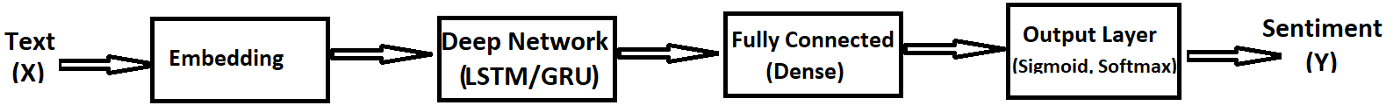

**Word Embedding** is a representation of text where words that have the same meaning have a similar representation. In other words it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. In the deep learning frameworks such as TensorFlow, Keras, this part is usually handled by an embedding layer which stores a lookup table to map the words represented by numeric indexes to their dense vector representations.

**Deep network** takes the sequence of embedding vectors as input and converts them to a compressed representation. The compressed representation effectively captures all the information in the sequence of words in the text. The deep neywrok part is usually an RNN or some forms of it like LSTM/GRU. The dropout is added to overcome the tendency to overfit, a very common problem with RNN based networks. Please refer here for detailed discussion on LSTM,GRU.

The **fully connected layer** takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.

**Output Layer** Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from six.moves import urllib
from six.moves import xrange

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,SpatialDropout1D,Flatten
from tensorflow.keras.layers import LSTM
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
import pandas as pd

In [5]:
print(np.__version__)
print(tf.__version__)

1.19.5
2.3.0


## DataSet
The IMDB movie review set can be downloaded from here. This dataset for binary sentiment classification contains set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 

In [97]:
max_features= 50000
print("loading data.....")

(X_train,y_train),(X_test,y_test)=imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

loading data.....
25000 train sequences
25000 test sequences


In [8]:
print("Shape of training and test data")
X_train.shape, X_test.shape

Shape of training and test data


((25000,), (25000,))

In [9]:
print("Shape of training and test labels")
y_train.shape, y_test.shape

Shape of training and test labels


((25000,), (25000,))

In [10]:
## Printing the size of first  10 records
for i in range(10):
    print(f"Length of {i} th record",len(X_train[i]))

Length of 0 th record 218
Length of 1 th record 189
Length of 2 th record 141
Length of 3 th record 550
Length of 4 th record 147
Length of 5 th record 43
Length of 6 th record 123
Length of 7 th record 562
Length of 8 th record 233
Length of 9 th record 130


this shows every record is of varied length. Thus we will need padding

In [11]:
print("Unique Training Data")
len(np.unique(X_train))

Unique Training Data


24902

In [12]:
print("Labels in train data")
y_train[:5]

Labels in train data


array([1, 0, 0, 1, 0], dtype=int64)

In [13]:
# Summarize number of words in training data
print("Number of unique words in training data: ")
print(len(np.unique(np.hstack(X_train))))

Number of unique words in training data: 
49998


In [14]:
# Summarize number of words in test data
print("Number of unique words in test data: ")
print(len(np.unique(np.hstack(X_test))))

Number of unique words in test data: 
40750


In [15]:
print("number of classes in train labels",np.unique(y_train))
print("number of classes in test labels",np.unique(y_test))

number of classes in train labels [0 1]
number of classes in test labels [0 1]


In [ ]:
24801 +24902+120

Review length: 
Mean 238.71 words (176.493674)


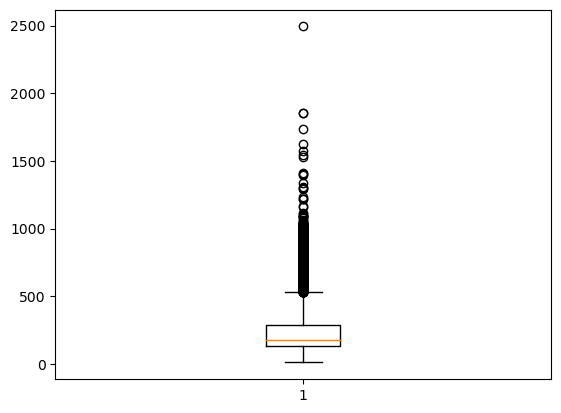

In [17]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

We can see that the average review has just under 250 words with a standard deviation of just over 170 words.

## Padding

In [118]:

maxlen=250 # decided this value after looking at the average value of the review length in the data set
batch_size=32
print('Pad sequences ')
X_train = sequence.pad_sequences(X_train,maxlen=maxlen)
X_test = sequence.pad_sequences(X_test,maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


Pad sequences 
X_train shape: (25000, 250)
X_test shape: (25000, 250)


In [146]:
print("One sample from train set:\n",X_train[0])
print("\nOne sample from train label:",y_train[0])

One sample from train set:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     1    14    22    16
    43   530   973  1622  1385    65   458  4468    66  3941     4   173
    36   256     5    25   100    43   838   112    50   670 22665     9
    35   480   284     5   150     4   172   112   167 21631   336   385
    39     4   172  4536  1111    17   546    38    13   447     4   192
    50    16     6   147  2025    19    14    22     4  1920  4613   469
     4    22    71    87    12    16    43   530    38    76    15    13
  1247     4    22    17   515    17    12    16   626    18 19193     5
    62   386    12     8   316     8   106     5     4  2223  5244    16
   480    66  3785    33     4   130    12    16    38   619     5    25
   124    51    36   135    48    25  1415    33     6    22    12   215
    28    77    52     

In [19]:
# Shape or length of one record after padding 
X_train[0].shape

(250,)

## Decode the feature value to get original sentence

In [24]:
# indices returned my keras have <START> and <UNKNOWN> as indexes 1 and 2.
# (And it assumes you will use 0 for <PADDING>).
NUM_WORDS=50000 # only use top 1000 words
INDEX_FROM=3  # word index offset
word_to_id = tf.keras.datasets.imdb.get_word_index()

word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}

word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[2] ))
print(y_train[2])

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or genera

## Building a Sequential Model using LSTM

## Embedding layer and Model building

the first layer of our model would be an word embedding layer created using the Embedding class

In [35]:
# Create callbacks
es=EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
print('Build model...')
model=Sequential()
model.add(Embedding(input_dim=max_features,output_dim=100, input_length=maxlen))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_test, y_test),callbacks=[es])
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Epoch 1/15
782/782 [==============================] - 1453s 2s/step - loss: 0.4574 - accuracy: 0.7786 - val_loss: 0.3257 - val_accuracy: 0.8686
Epoch 2/15
782/782 [==============================] - 1128s 1s/step - loss: 0.2848 - accuracy: 0.8903 - val_loss: 0.3181 - val_accuracy: 0.8718
Epoch 3/15
782/782 [==============================] - 979s 1s/step - loss: 0.2193 - accuracy: 0.9168 - val_loss: 0.4402 - val_accuracy: 0.8667
Epoch 4/15
782/782 [==============================] - 1024s 1s/step - loss: 0.1514 - accuracy: 0.9445 - val_loss: 0.3401 - val_accuracy: 0.8650
Epoch 5/15
782/782 [==============================] - 972s 1s/step - loss: 0.1319 - accuracy: 0.9510 - val_loss: 0.4205 - val_accuracy: 0.8548
Epoch 6/15
782/782 [==============================] - 679s 868ms/step - loss: 0.0955 - accuracy: 0.9654 - val_loss: 0.4188 - val_accuracy: 0.8625
Epoch 7/15
782/782 [==============================] - 39s 50ms/step - loss: 0.3181 - accuracy: 0.8718
Test score

## Create a plot of accuracy and loss over time

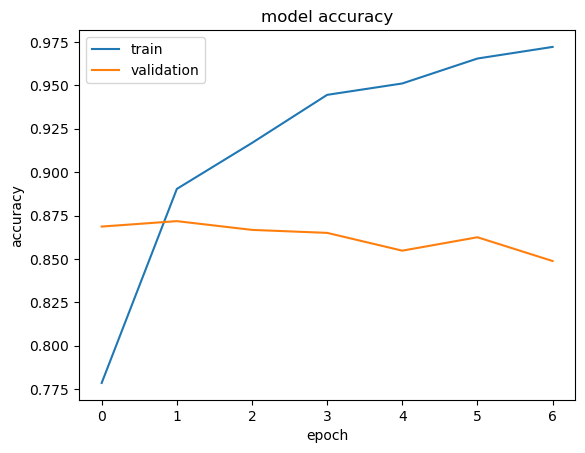

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();



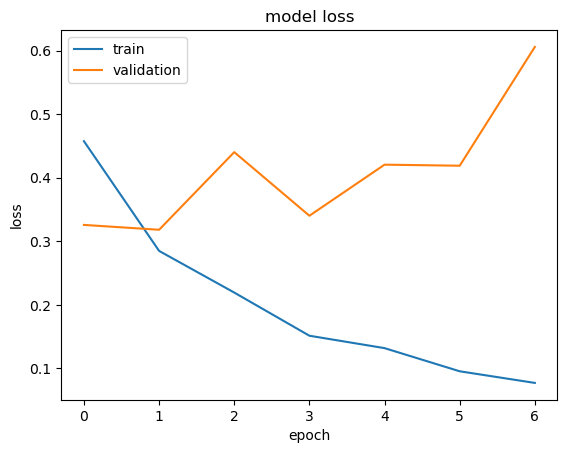

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [65]:
print("Test-loss:", np.mean(history.history["loss"]))
print("Test-Accuracy:", np.mean(history.history["accuracy"]))

Test-loss: 0.20249072462320328
Test-Accuracy: 0.9169600009918213


In [148]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve
print(classification_report(y_test,np.round(model.predict(X_test))))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     12500
           1       0.89      0.85      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## Doing  Predictions on new Data

In [99]:
stop_words= set(stopwords.words("english"))
def Preparing_string(text_string, dimension = max_features):
        text_string = text_string.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        text_string = text_string.translate(table)
    
        word2index = imdb.get_word_index()
        test=[]
        
        # remove punctuations
        punct_free="".join([t for t in text_string if t not in string.punctuation ])
        # tokenize
        tokens= word_tokenize(punct_free)
        # convert to lower case
        tokens=[ word.lower() for word in tokens]
        # remove leading and traiing spaces
        tokens=[ word.strip() for word in tokens]
        # remove stop words
        words= [ word for word in tokens if word not in stop_words]
        
        for word in words:
            test.append(word2index[word])
            
        print(test)    
            
        results = np.zeros(dimension)
        for _ , sequence in enumerate(test):
            if sequence < dimension:
                results[sequence] = 1
        #results=sequence.pad_sequences(test,maxlen=maxlen)
    
        print("\nOriginal string:", text_string,"\n")
        print("\nIndex conversion:", test,"\n")
        results = np.reshape(results,(1, max_features))
        print("\nConvert to vectors:", results,"\n")
        return results

In [100]:
import string
from nltk import word_tokenize
data_string = Preparing_string("First off, this is NOT a war film. It is a movie about the bond of men in war. It is by far the best movie I've seen in a very, very long time. I had high expectations and was not disappointed. At first I was eager to see the one shot idea Sam Mendes went into this with but, after awhile, I stopped paying attention to that. While everything about the movie was well done I was so caught up in the two central characters that nothing else mattered. I will watch this again and again.")
print("predict:",model.predict(data_string))
print("predict_classes:",model.predict_classes(data_string))
print("------1 is Good-------\n")
data_string = Preparing_string("One of the best films I've seen in a long while. Worth seeing on a big screen. Cinematography is outstanding, the one shot process really makes you feel as though you are there. The two leading actors really grasped the concept that human contact can be so strong, especially in such awful situations as war. Insightful, moving and an overall amazing watch.")
print("predict:",model.predict(data_string))
print("predict_classes:",model.predict_classes(data_string))
print("------1 is Good-------\n")
data_string = Preparing_string("I felt dirty, I felt tired, I felt hungry, I felt a will to succeed and I felt sadness when I was watching the movie. It felt like I was also fighting to reach Colonel MacKenzie for two hours. Several hours later after my emotions are still outside my body. Fantastic photo and music. Good casting of staff. The movie is just perfect!")
print("predict:",model.predict(data_string))
print("predict_classes:",model.predict_classes(data_string))
print("------1 is Good-------\n")
data_string = Preparing_string("I don't feel like I know the characters at all. I have no idea why the two soldiers were friends or what they had been through together. The cinematography tried so hard to make this an emotional shocking movie that it had the opposite effect. War scenes with gratuitous up close views of corpses and body parts that don't add anything to the story got old quick.")
print("predict:",model.predict(data_string))
print("predict_classes:",model.predict_classes(data_string))
print("------0 is Bad-------\n")
data_string = Preparing_string("Predictable and horrendous. The acting was terrible and the story was common and nonsense. The only exciting part about the movie was the very end when finally people were dying and it represented WW1. I highly doubt he met a strange woman with an abandoned child and I highly doubt any of this even happened. This movie was Saving Private Ryan, but boring and predictable.")
print("predict:",model.predict(data_string))
print("predict_classes:",model.predict_classes(data_string))
print("------0 is Bad-------\n")

[83, 322, 19, 17, 1645, 346, 322, 227, 115, 17, 18778, 107, 193, 55, 309, 1395, 682, 83, 4508, 64, 28, 321, 323, 1281, 11748, 432, 5233, 2227, 2645, 689, 282, 17, 70, 221, 1056, 104, 1372, 102, 161, 331, 12943, 103]

Original string: first off this is not a war film it is a movie about the bond of men in war it is by far the best movie ive seen in a very very long time i had high expectations and was not disappointed at first i was eager to see the one shot idea sam mendes went into this with but after awhile i stopped paying attention to that while everything about the movie was well done i was so caught up in the two central characters that nothing else mattered i will watch this again and again 


Index conversion: [83, 322, 19, 17, 1645, 346, 322, 227, 115, 17, 18778, 107, 193, 55, 309, 1395, 682, 83, 4508, 64, 28, 321, 323, 1281, 11748, 432, 5233, 2227, 2645, 689, 282, 17, 70, 221, 1056, 104, 1372, 102, 161, 331, 12943, 103] 


Convert to vectors: [[0. 0. 0. ... 0. 0. 0.]] 

predi

## Doing Predictions on randomly selected samples from test data

In [129]:
examples=[]
indexes=[]
for i in range(10):
    index=np.random.randint(200,1000)
    indexes.append(index)
    examples.append((X_test[index]))

In [130]:
y_preds=model.predict_classes(np.reshape(examples,(-1,250)))

In [138]:

y_actuals=y_test[indexes]
print(pd.DataFrame({"Actuals":y_actuals,"Predictions":y_preds.ravel()}).reset_index(drop=True))

   Actuals  Predictions
0        1            0
1        0            0
2        1            0
3        0            0
4        1            1
5        0            0
6        0            0
7        0            0
8        1            1
9        1            1


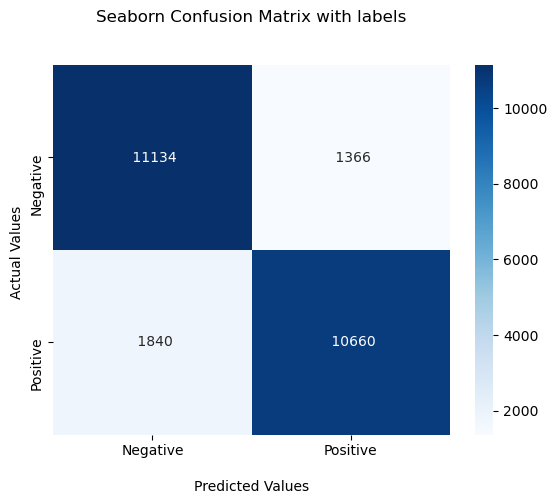

In [149]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix(y_test,model.predict_classes(X_test)), annot=True, cmap='Blues',fmt=' ')
# Here, you’ll store heatmap in variable ax.

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

Instructions for updating:
Please use `model.predict()` instead.
Area under the curve 0.9413572415999999


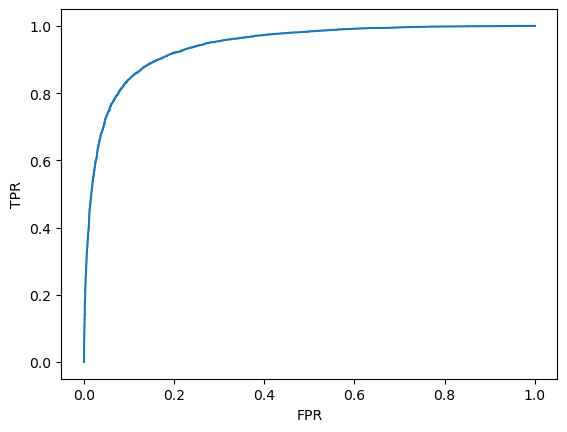

In [150]:
fpr,tpr,_= roc_curve(y_test,model.predict_proba(X_test))
auc=roc_auc_score(y_test,model.predict_proba(X_test))
print("Area under the curve",auc)
plt.plot(fpr,tpr,label="Sarcasm data, auc="+str(auc*100)+"%")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()